In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras_preprocessing import image
from keras_preprocessing.image import img_to_array



img_dir = 'helmet_generation'  # 이미지가 들어있는 폴더 경로
img_width = 64  # 이미지 가로 길이
img_height = 64  # 이미지 세로 길이

# 이미지를 numpy array로 변환
def img_to_np_array(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    x = img_to_array(img)
    return x

# 이미지 경로와 라벨을 읽어들임
image_paths = []
labels = []
for subdir, _, files in os.walk(img_dir):
    for file in files:
        img_path = os.path.join(subdir, file)
        if img_path.endswith(".png"):
            label = img_path.split("/")[-1]  # 폴더 이름을 라벨로 사용
            image_paths.append(img_path)
            labels.append(label)

# 이미지를 numpy array로 변환
X = np.array([img_to_np_array(img_path) for img_path in image_paths])
y = np.array(labels)

# train/test set으로 나눔
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Without_Helmet에 해당하는 파일은 0, With_Helmet에 해당하는 파일은 1로 바꿔줌
y_train = np.array([0 if 'Without_Helmet' in label else 1 for label in y_train])
y_test = np.array([0 if 'Without_Helmet' in label else 1 for label in y_test])

In [4]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, add, Flatten, GlobalAveragePooling2D, concatenate, Reshape, multiply
from keras.models import Model

from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, add, Flatten, AveragePooling2D, concatenate
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from keras.utils import np_utils

In [5]:
def SEmodule(pre_layer, ch, r): 
  #pre_layer : 입력(w,h,c), ch : channel, r :16
  
    x = GlobalAveragePooling2D()(pre_layer)

    x = Dense(int(ch/r), activation='relu')(x) #int(ch/r) 나누어 떨어지지 않을 수 있기 때문 >> 정수
    
    x = Dense(ch, activation='sigmoid')(x)

    x = Reshape((1, 1, ch))(x) #1x1xchannel vector로 변환 

    x = multiply([pre_layer,x]) # 가중치 반영부분 (channel by channel별로 가중치)
    
    return x

In [6]:
def inception(x, filters): 
    pre_layer = x
    
    f1,f2,f3,f4 = filters

    # 1x1
    conv1 = Conv2D(f1, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    
    # 1x1 & 3x3
    conv2 = Conv2D(f4  , kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv2 = Conv2D(f2, kernel_size=(3,3), padding='same', activation='relu')(conv2)

    # 1x1 & 5x5
    conv3 = Conv2D(f4, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv3 = Conv2D(f3, kernel_size=(5,5), padding='same', activation='relu')(conv3)
    
    # pooling & 1x1
    max_pool = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(pre_layer)
    max_pool = Conv2D(f4, kernel_size=(1,1), padding='same')(max_pool)

    # output = [None(batch_size), w,h,c], c 기준 concatenate (axis = -1 )
    concat = concatenate([conv1, conv2, conv3, max_pool], axis=-1)
    
    x = SEmodule(concat, f1+f2+f3+f4, 16)

    return x #concat
    

In [7]:
input_shape = X_train[0].shape    
inputs = Input(shape=input_shape)

# conv랑 batch 사이에 max pooling 들어가야 하나, cifar 데이터에선 크기 너무 줄어들어서 뺐음
x = Conv2D(128, kernel_size=(7,7), strides=2, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(192, kernel_size=(3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x) 


# inception 3a
x = inception(x,[64,128,32,32])
# inception 3b
x = inception(x,[128,192,96,64])
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

# inception 4a
x = inception(x,[192,208,48,64])
aux1 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
aux1 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux1)
aux1 = Flatten()(aux1)
aux1 = Dense(512, activation='relu')(aux1)
aux1 = Dense(1, activation='sigmoid')(aux1)

# inception 4b
x = inception(x,[160,224,64,64])


# inception 4c
x = inception(x,[128,256,64,64])
# inception 4d
x = inception(x,[112,288,64,64])
aux2 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
aux2 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux2)
aux2 = Flatten()(aux2)
aux2 = Dense(832, activation='relu')(aux2)
aux2 = Dense(1, activation='sigmoid')(aux2)


# inception 4e
x = inception(x,[256,320,128,128])


# inception 5a
x = inception(x,[256,320,128,128])
# inception 5b
x = inception(x,[384,384,128,128])
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=[aux1, aux2, outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', loss_weights=[0.3,0.3,1.0], metrics=['accuracy']) 


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 128)  18944       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 192)  221376      ['batch_normalization[0][0]']

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
modelpath = 'modelll/'
if not os.path.exists(modelpath) :
    os.mkdir(modelpath)

checkpointer = ModelCheckpoint(filepath = modelpath + 'google_early.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=10)

In [13]:
history = model.fit(X_train, y_train, validation_data=[X_test, y_test], epochs = 50,  batch_size = 32,  callbacks = [checkpointer, early_stopping_callback])

Epoch 1/50
500/500 [==============================] - ETA: 0s - loss: 0.1605 - dense_7_loss: 0.0908 - dense_15_loss: 0.0972 - dense_22_loss: 0.1041 - dense_7_accuracy: 0.9688 - dense_15_accuracy: 0.9672 - dense_22_accuracy: 0.9636
Epoch 1: val_loss improved from inf to 0.51409, saving model to modelll\google_early.hdf5
500/500 [==============================] - 43s 80ms/step - loss: 0.1605 - dense_7_loss: 0.0908 - dense_15_loss: 0.0972 - dense_22_loss: 0.1041 - dense_7_accuracy: 0.9688 - dense_15_accuracy: 0.9672 - dense_22_accuracy: 0.9636 - val_loss: 0.5141 - val_dense_7_loss: 0.4462 - val_dense_15_loss: 0.3033 - val_dense_22_loss: 0.2893 - val_dense_7_accuracy: 0.8200 - val_dense_15_accuracy: 0.8565 - val_dense_22_accuracy: 0.8692
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 0.0925 - dense_7_loss: 0.0524 - dense_15_loss: 0.0544 - dense_22_loss: 0.0605 - dense_7_accuracy: 0.9821 - dense_15_accuracy: 0.9812 - dense_22_accuracy: 0.9787
Epoch 2: val_loss improve

In [3]:
from tensorflow.keras.models import load_model

In [23]:
acc = history.history['dense_22_accuracy']
val_acc = history.history['val_dense_22_accuracy']

print('정확도(accuracy) : ', max(acc))
print('정확도(accuracy) : ', max(val_acc))

정확도(accuracy) :  0.9986249804496765
정확도(accuracy) :  0.9975000023841858


In [19]:
from sklearn.metrics import f1_score, precision_score

In [4]:
y_pred = model.predict(X_test)



NameError: name 'model' is not defined

In [64]:
y_test

array([1, 0, 0, ..., 0, 0, 1])

In [68]:
y_pred = np.round(y_pred)
y_pred[-1]
y_pred=y_pred[-1]

In [70]:
f1 = f1_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred)* 100

In [71]:
print(f1)
print(precision)
print(recall)

99.18864097363084
99.64340295466123
98.73801110550228


In [5]:
best_model = load_model(f'modelll/google_early.hdf5')


In [6]:
from PIL import Image
tb_img = ['yyb.png']
tb_img_1 = []
for i in range(len(tb_img)):
    img = Image.open(tb_img[i])
    tb_img_1.append(img.resize((64,64)))

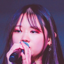

In [7]:
tb_img_1[0]

In [8]:
import numpy as np

In [9]:
tb_img_1[0]
img = np.array(tb_img_1[0])/255
img = img.reshape(1, 64, 64, -1)
img.shape

(1, 64, 64, 3)

In [10]:
best_model.predict(img)

1/1 [==============================] - 3s 3s/step


[array([[0.9981371]], dtype=float32),
 array([[0.07618283]], dtype=float32),
 array([[0.34471014]], dtype=float32)]